# ODE model

models and fit functions for ODEs coming from a master equation. 
linear reaction where you just have rates forward

example:
$$ \text{AAAA} \xrightarrow{k0} \text{AAA} \xrightarrow{k1} \text{AA} $$

In [23]:
#| default_exp ode

In [24]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit

In [25]:
# | export
def initialize_params(data, initial_guess, initial_guess_bounds=[0.0001, 1], vary_initial_conditions=False):
    initial_conditions = list(data[0,:])
    params = Parameters()
    for nm,i in enumerate(initial_conditions):
        params.add('x'+str(nm + 1)+'0', value=i, vary=vary_initial_conditions)
    for nm, k in enumerate(initial_guess):
        params.add('k'+str(nm), value=k, min=initial_guess_bounds[0], max=initial_guess_bounds[1])
    return params

In [26]:
x = np.array([[1,2,3], [4,5,6]])
initial_guess= [0.1, 0.2, 0.3]
test_init_params = initialize_params(x, initial_guess)
assert test_init_params['k1'] == 0.2
assert list(test_init_params.keys()) == ['x10', 'x20', 'x30', 'k0', 'k1', 'k2' ]

In [27]:
# | export 
def k_matrix(params):
    params_k_list = [k for k in params.keys() if 'k' in k]
    m = len(params_k_list)
    n = m + 1

    k = np.eye(n,m, k=-1) - np.eye(n,m)
    k_values = [params[k] for k in params_k_list]
    return k_values * k

In [28]:
test_params = {'a':1/3,'k1':1,'k2':20, 'k3':300}
out = np.array([[-1, 0, 0], [1,-20, 0], [0, 20, -300], [0, 0, 300]])
assert (k_matrix(test_params) == out).all()

In [29]:
# | export 
def _master_equations(y, t, paras):
    """
    Your system of differential equations
    # f0 = -k0 * x1
    # f1 = k0 * x1 - k1 * x2
    # ...
    # fn-1 = kn-2 * x2 - kn-1 * x3
    # fn = kn-1 * xn-1
    fn need to be solve using odeint
    """

    rates = k_matrix(paras)
    dydt = rates.dot(y[:-1])
    return dydt

In [30]:
test_params = {'a':1/3,'k1':1,'k2':20, 'k3':300}
M = np.array([[-1, 0, 0], [1,-20, 0], [0, 20, -300], [0, 0, 300]])
xs = np.array([1, 1/10, 1/100, 500])
out = np.array([-1, -1, -1, 3])
_master_equations(xs, 0, test_params)
assert (_master_equations(xs, 0, test_params) == out.T).all()

In [31]:
# | export 
def ode_solver(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(_master_equations, x0, t, args=(paras,))
    return x

In [32]:
# | export 
def plot_fitted(t_fit, data_fitted, measured, model_result):
    t_measured = measured[:,0]
    x_measured =  measured[:,1:]
    # plot fitted data
    plt.plot(t_fit, data_fitted, '-', linewidth=2, color='red', label='fitted data')
    for i, xi_measured in enumerate(x_measured.T):
        plt.scatter( t_measured, xi_measured, marker='o', color='b', label= 'X' + str(i))
    plt.legend()
    plt.xlim([0, np.max(t_measured)])
    plt.ylim([0, 1.1 * np.max(data_fitted)])
    # display fitted statistics
    report_fit(model_result)

    plt.show()

In [33]:
# | export 
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """
    x0 = [paras[x].value for x in paras.keys() if 'x' in x]
    # x0 = paras['x10'].value, paras['x20'].value, paras['x30'].value, paras['x40'].value
    model = ode_solver(t, x0, paras)

    return ((model - data)).ravel()


# Simulate Process

In [34]:
# fixed error
time_limit = 10
num_chain_reaction = 4

k0 = 0.3
k1 = 0.1
k2 = 0.6

x = np.zeros((time_limit+1, num_chain_reaction))
x[0,:] = np.array([1000, 0, 0 , 0])

noise_dev = np.random.gamma(3, 0.8, (time_limit, 3))
scale = 0.1

for t in range(1, time_limit + 1):
    proc1, proc2, proc3 = np.random.normal(scale= scale), np.random.normal(scale= scale), np.random.normal(scale= scale)
    x[t, 0] = x[t-1, 0] - (x[t-1, 0] * (k0 + proc1))
    x[t, 1] = x[t-1, 1] + ((x[t-1, 0] * (k0 + proc1)) - (x[t-1, 1] * (k1 + proc2)))
    x[t, 2] = x[t-1, 2] + ((x[t-1, 1] * (k1 + proc2)) - (x[t-1, 2] * (k2 + proc3)))
    x[t, 3] = x[t-1, 3] + (x[t-1, 2] * (k2 + proc3))
x = np.abs(x)

<AxesSubplot:xlabel='time', ylabel='count'>

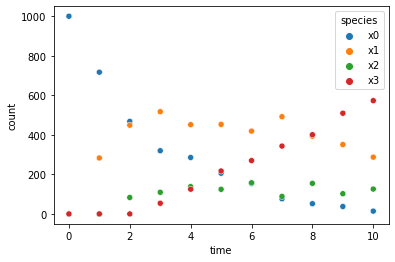

In [35]:
import pandas as pd
import seaborn as sns
time = np.arange(0, time_limit +1, 1)
time
df_x = pd.DataFrame(x, columns=['x0','x1', 'x2', 'x3'], index=pd.Series(time,  name='time')).reset_index().melt(id_vars='time', value_name='count', var_name='species')
sns.scatterplot(data=df_x, x='time', y='count', hue='species') 


In [36]:
# Fit

# set parameters including bounds; you can also fix parameters (use vary=False)
params = initialize_params(x, [0.1,0.1,0.1])


# fit model
result = minimize(residual, params, args=(time, x), method='leastsq')  # leastsq nelder
# check results of the fit
t_fit = np.linspace(0., 10., 100)
data_fitted = ode_solver(t_fit, x[0,:], result.params)




[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 44
    # variables        = 3
    chi-square         = 27274.6665
    reduced chi-square = 665.235768
    Akaike info crit   = 288.899054
    Bayesian info crit = 294.251623
[[Variables]]
    x10:  1000 (fixed)
    x20:  0 (fixed)
    x30:  0 (fixed)
    x40:  0 (fixed)
    k0:   0.34814302 +/- 0.00861182 (2.47%) (init = 0.1)
    k1:   0.17016261 +/- 0.00460187 (2.70%) (init = 0.1)
    k2:   0.55061817 +/- 0.03520856 (6.39%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.290
    C(k0, k2) = -0.183
    C(k0, k1) = -0.110


/home/e.marinelli_cbs-niob.local/.conda/envs/diffdig/lib/python3.7/site-packages/lmfit/printfuncs.py:177: RuntimeWarning: invalid value encountered in double_scalars
  spercent = f'({abs(par.stderr/par.value):.2%})'


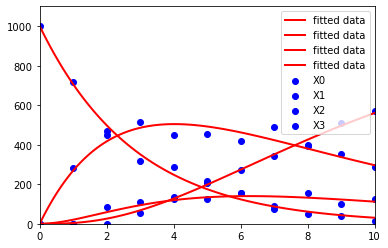

In [37]:
measured = np.concatenate((time.reshape(-1,1), x), axis=1)
plot_fitted(t_fit, data_fitted, measured , result)

<AxesSubplot:xlabel='time', ylabel='count'>

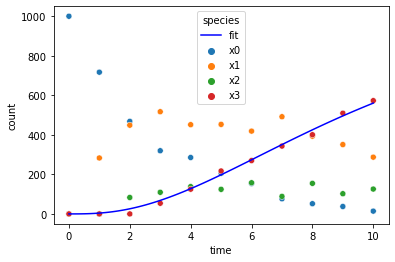

In [38]:
plt.plot(t_fit, data_fitted[:,3], color='b', label='fit')
sns.scatterplot(data=df_x, x='time', y='count', hue='species')

In [39]:
# | export 

In [40]:
# | export 

In [1]:
#| hide
import nbdev; nbdev.nbdev_export()

ModuleNotFoundError: No module named 'nbdev'